### Compilation/Generation Benchmark:

#### Requirements for running:
- ZoKrates installed (via install script)


#### Select files:
- Drop all files that are supposed to be benchmarked in the files/ directory in this project

#### Python Imports:

In [13]:
%%capture
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
import os
import math
import matplotlib.pyplot as plt
import numpy as np

#### Iterate Files:

##### Benchmark Settings:
- Each programm will be run N * R times
    - N: Number of executions in one loop
    - R: Number of loop executions

In [14]:
%%capture
compile_time = []
setup_time = []
witness_time = []
proof_time = []
constraints = []
# Set N and R here
%alias_magic benchmark timeit -p "-n 1 -r 1 -o"

def compile_file(file):
    value = %benchmark !zokrates compile -i files/{file}
    return int(value.best * 1000000)
    
# counts constraints by looking into out.code
def count_constraints():
    f = open("./out.code",'r')
    constraints.append(len(list(filter(lambda x: "==" in x, f.readlines()))))
    
def setup():
    value = %benchmark !zokrates setup --light
    return int(value.best * 1000000)

'''
this method gets the first line of given .code file and extracts function parameters.
Expected format: 
    -commented out in first line of file with a space after '//'

E.g.

// 337 113569
def main(private field a, field b) -> (field):
  field result = if a * a == b then 1 else 0 fi
  return result
'''
def get_parameters(file):
    with open('files/' + file) as f:
        line = f.readline()
        if "//" in line:
            return "-a" + line.replace("//", "")
        else:
            return ""
        
def compute_witness(file):
    params = get_parameters(file)
    value = %benchmark !zokrates compute-witness {params} --light
    return int(value.best * 1000000)

def generate_proof():
    value = %benchmark !zokrates generate-proof --light
    return int(value.best * 1000000)

#Sorts all lists based on constraint count
def sort_res():
    return zip(*sorted(zip(constraints, compile_time, setup_time, witness_time, proof_time)))
    
for file in os.listdir('./files'):
    compile_time.append(compile_file(file))
    setup_time.append(setup())
    witness_time.append(compute_witness(file))
    proof_time.append(generate_proof())
    count_constraints()
    
constraints, compile_time, setup_time, witness_time, proof_time = sort_res()

FileNotFoundError: [Errno 2] No such file or directory: './out.code'

In [6]:
print(compile_time)
print(setup_time)
print(witness_time)
print(proof_time)
print(constraints)

[115175, 109418, 113024]
[114199, 111039, 114187]
[112579, 114243]
[114426, 110035]
[2962, 2962]


#### Compilation and Setup Diagram:


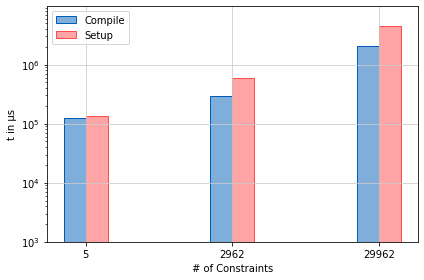

In [11]:
x = np.arange(len(constraints))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, compile_time, width, label='Compile', edgecolor='#005eb8', color='#7faedb')
rects2 = ax.bar(x + width/2, setup_time, width, label='Setup', edgecolor='#ff4c4c', color='#ffa5a5')
ax.set_ylabel('t in μs')
ax.set_xticks(x)
ax.set_xlabel('# of Constraints')
ax.set_xticklabels(constraints)
ax.legend()
ax.semilogy(np.exp(0 / max(setup_time)))
ax.set_ylim(ymin=1000)
fig.tight_layout()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
plt.savefig('exports/compile-setup.png')
plt.show()

#### Witness and Proof Diagram:

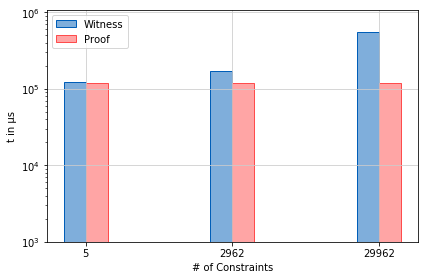

In [12]:
x = np.arange(len(constraints))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, witness_time, width, label='Witness', edgecolor='#005eb8', color='#7faedb')
rects2 = ax.bar(x + width/2, proof_time, width, label='Proof', edgecolor='#ff4c4c', color='#ffa5a5')
ax.set_ylabel('t in μs')
ax.set_xticks(x)
ax.set_xlabel('# of Constraints')
ax.set_xticklabels(constraints)
ax.legend()
ax.semilogy(np.exp(0 / max(setup_time)))
ax.set_ylim(ymin=1000)
fig.tight_layout()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
plt.savefig('exports/witness-proof.png')
plt.show()